# Fang & Oosterle (2008) : A novel pricing method for european options based on Fourier-Cosine series expansions (Part I/II) and Heston (1993)

The goal of the Heston Model is the pricing of options based on the Heston stochastic volatility model (Heston, 1993). To solve the Heston Model, we use Fang and Osterle's (2008) COS-FFT transformation. With the COS-FFT, we are able to calculate the p.d.f. of a characteristic function on a general interval. The density of the probabilistic function of the Heston model is  used to calculate option prices.

Formulas and text are from [Fang & Oosterle 2008](https://search.proquest.com/docview/921045379?pq-origsite=gscholar) paper. Chapter and equation numbers also correspond)

In [1]:
%matplotlib inline

import time
import cmath   # c stands for complex (to handle complex numbers)
import collections
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gamma as gamma_fn

import warnings
warnings.simplefilter('ignore')

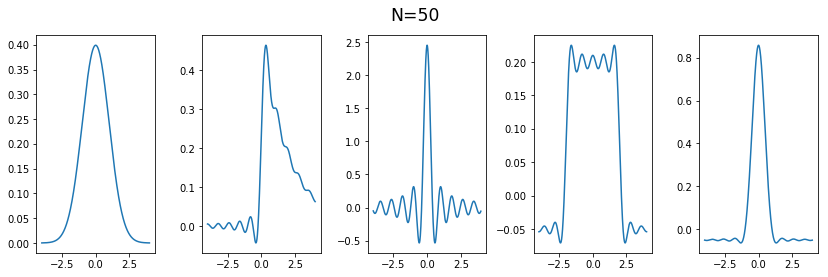

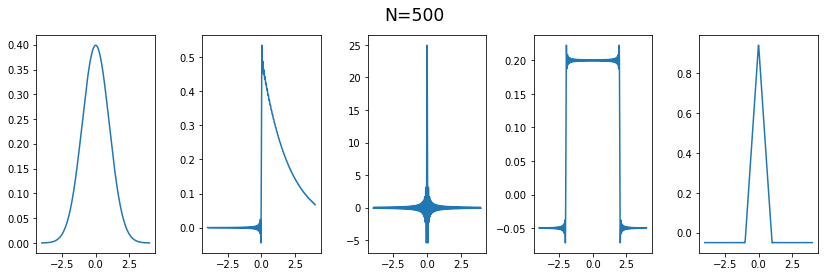

In [2]:
# import density functions from other python file
from cos_fft_densities import get_values

## 3. Pricing European Options

### 3.1. Coeﬃcients $V_k$ for Plain Vanilla Options
Before we can price options, the payoﬀ series coeﬃcients, $V_k$ , have to be recovered. We can ﬁnd analytic solutions for $V_k$ for several contracts (Fang & Ooesterle, 2008)

Both the cosine series coeﬃcients, $\chi_k$  and $\psi_k$ are known analytically.

<img style="float: left;" src="figures/f_22_23.png" width="580">


In [3]:
# equation (22)
def chi_cosine_series_coeff(k, a, b, c, d):
    """
    Helper Function (22) in the F&O paper
    Args:
        k : coeﬃcients of the summand (runs from 0 to N-1)
        a : float, left border of the trucated integral
        b : float, right border of the truncated integral 
        c : 0
        d : a or b
    Returns:
        chi_k : ndarray with N floats, a cosine series coefficient ndarray
    """
    multiplier = 1 / (1 + (k* np.pi / (a - b))**2 )
    
    cos1 = np.cos( k * np.pi * ( (d-a)/(b-a) ) ) * np.exp(d)
    cos2 = np.cos( k * np.pi * ( (c-a)/(b-a) ) ) * np.exp(c)
    
    sin1 = (k * np.pi)/(b-a) * np.sin( k * np.pi * ( (d-a)/(b-a) ) ) * np.exp(d)
    sin2 = (k * np.pi)/(b-a) * np.sin( k * np.pi * ( (c-a)/(b-a) ) ) * np.exp(c)
    
    in_brakets = cos1 - cos2 + sin1 - sin2

    return multiplier * in_brakets
    
# equation (23)
def psi_cosine_series_coeff(k, a, b, c, d):
    """
    Helper Function (23) in the F&O paper
    Args:
        k : int, coeﬃcients of the summand (runs from 0 to N-1)
        a : float, left border of the trucated integral
        b : float, right border of the truncated integral
        c : 0
        d : a oder b
        
    Returns:
        psi_k : ndarray with N floats, a cosine series coefficient ndarray
    """
    # handles 2 cases, the first if k is only an integer, the second if
    # k is an array. k is an array if we use the vectorized compuatation of 
    # the sum
    
    pi = np.pi
    
    if isinstance(k, int): 
        if k == 0:
            return (d-c)
    
    sin1 = np.sin(k * pi * (d-a)/(b-a))
    sin2 = np.sin(k * pi * (c-a)/(b-a))
    in_brakets = sin1 - sin2

    y = in_brakets * (b-a) / (k * pi)

    if isinstance(k, np.ndarray):

        y[0] = (d-c)
        
    return y
        

### 3.3. Formula for Lévy Processes and the Heston Model

<img style="float: left;" src="figures/Uk.png" width="680">

In [4]:
def UK(k, a, b, style):
    """
    Helper function for COS_FFT, (Fang & Osterle (2008), p. 6-7. )
    Equation (29) in F&O paper. Calculates Uk.
    Uses formula (22) and (23)
    In:
        k : int, coeﬃcients of the summand (runs from 0 to N-1)
        a : float, left border of the trucated integral
        b : float, right border of the truncated integral
        style: bool, indicating whether the option is a call
    Returns:
        U:        ndarray of N floats, function value of UK
    """    
    # if the option is a call
    if style == 'call':
        chi_k = chi_cosine_series_coeff(k, a, b, 0, b) 
        psi_k = psi_cosine_series_coeff(k, a, b, 0, b)

        return (2 / (b - a)) * (chi_k - psi_k)
        
    # if the option is a put
    elif style == 'put':
        chi_k = chi_cosine_series_coeff(k, a, b, a, 0) 
        psi_k = psi_cosine_series_coeff(k, a, b, a, 0)
        
        return (2 / (b - a)) * (-chi_k + psi_k)

### Lévy

For the CGMY/KoBol model, which encompasses the __Geometric Brownian Motion (GBM)__ and __Variance Gamma (VG)__ models, the characteristic function of the log-asset price is of the form:

<img style="float: left;" src="figures/f_31.png" width="680">
<img style="float: left;" src="figures/f_56.png" width="480">

In [5]:
class LevyCharFunction:
    """
    We use a class 
    """
    def __init__(self, model):
        """
        Initial values according to (56) in F&O paper
        """
        self.model = model
       
        # make sure that one of the three possible model is used as an input
        error_message = "Model input is not suitable, please use one of either 'CGMY', 'GBM', or 'VG' as a model for the levy characteristic function"
        assert self.model in ['CGMY', 'GBM','VG'], error_message
        
        self.r = 0.1
        self.q = 0.
        self.mu = self.r
        
        if self.model == 'CGMY':
            self.C = 1.
            self.G = 5.
            self.M = 5.
            self.Y = 0.5
            self.sigma = 0.12  # as in (55)
            
        # Geometric Brownian Motion 
        elif self.model == 'GBM':
            self.C = 0.    # if C == 0, the values of G,M,Y don't matter
            self.G = 0.5
            self.Y = 0.5
            self.M = 0.5
            self.sigma = 0.25  # as in eq(51)

        # Variance Gamma
        elif self.model == 'VG':
            # according to (55)
            self.sigma = 0.12
            self.theta = -0.14
            self.nu = 0.2
            
            self.Y = 0.   # as described on page 8 
            
            # C,G and M are defined as in (54)
            self.C = 1 / self.nu
            
            inside_sqrt = self.theta**2/self.sigma**4 + 2/(self.nu*self.sigma**2)

            self.G = self.theta / self.sigma**2 + cmath.sqrt(inside_sqrt)
            self.M = -self.theta/self.sigma**2 + cmath.sqrt(inside_sqrt)
            
    def evaluate(self, omega, tau):
        """
        Defined in eq(31) F&O paper, actually does the calculation of the
        characteristic function.
        """

        exp1 = np.exp(1j*omega*(self.r-self.q)*tau-0.5*omega**2*self.sigma**2*tau)
        
        if self.Y != 0:
            first = (self.M-1j*omega)**self.Y - self.M**self.Y
            second = (self.G+1j*omega)**self.Y - self.G**self.Y
            in_brackets = first + second
            exp2 = np.exp((tau*self.C*gamma_fn(-self.Y))*in_brackets)
        
            return exp1 * exp2
        
        # because Y=0 causes exp2 to be equal to 1
        else:   
            return exp1
        
        
    def get_ab(self, tau):
        """
        Returns the borders a and b
        Defined in appendix, Table 11
        """
        if self.model == 'GBM':
            c1 = self.mu * tau
            c2 = self.sigma**2 * tau
            c4 = 0
        
        elif self.model == 'VG':
            c1 = (self.mu + self.theta) * tau
            c2 = (self.sigma**2 + self.nu*self.theta**2) * tau
             
            first_summand = self.sigma**4 *self.nu
            second_summand = 2* self.theta**4 *self.nu**3
            third_summand = 4* self.sigma**2 *self.theta**2 *self.nu**2
            in_braces =  first_summand + second_summand + third_summand
            c4 = 3 * in_braces * tau
        
        elif self.model == 'CGMY':
            first_multip = self.C*tau*gamma_fn(1-self.Y)
            second_multip = self.M**(self.Y-1)-self.G**(self.Y-1)
            c1 = self.mu*tau + first_multip * second_multip

            first_multip = self.C*tau*gamma_fn(2-self.Y)
            second_multip = self.M**(self.Y-2)+self.G**(self.Y-2)
            c2 = self.sigma**2*tau + first_multip * second_multip
            
            first_multip = self.C*tau*gamma_fn(4-self.Y)
            second_multip = self.M**(self.Y-4)-self.G**(self.Y-4)
            c4 = first_multip * second_multip

        # eq(49)
        root = np.sqrt( c2 + np.sqrt(c4) )
        a_param = c1 - 10*root 
        b_param = c1 + 10*root
        
        return a_param, b_param 

In [6]:
char_func = LevyCharFunction('CGMY')

### Heston
<img style="float: left;" src="figures/heston.png" width="480">

In [7]:
class HestonCharFunction:
    def __init__(self):
        """
        Characteristic function of Heston Model based on Fang & Oosterle (2008), p. 8.

        self.u_0 = variance at t=0
        self.lam = mean reversion
        self.eta = volatility of volatility
        self.mu = drift of Brownian Motion (here interest rate)
        self.rho = correlation coefficient Brownian Motion
        self.uBar = mean level of variance

        """
        self.model = "Heston"
        
        # parameters as in (53)
        self.r = 0.
        self.q = 0.

        self.u_0 = 0.0175
        self.lam = 1.5768
        self.eta = 0.5751
        self.mu = self.r
        self.rho = -0.5711 
        self.uBar = 0.0398
    
    def evaluate(self, ome, tau):
        """
        ome = ndarray of length N
        tau = years to maturity

        Returns ndarray of N floats
        """

        first = ( self.lam - 1j * self.rho * ome * self.eta ) ** 2
        second = ( ome ** 2 + ome * 1j ) * self.eta ** 2
        D = (first + second) ** (0.5)

        nom = (self.lam - 1j * self.rho * ome * self.eta - D)
        denom = (self.lam - 1j * self.rho * ome * self.eta + D)
        G = nom / denom

        first_summand = 1j * ome * self.mu * tau

        first_factor = (self.u_0 / self.eta ** 2)
        second_factor = (1 - np.exp(-D * tau)) / (1 - G * np.exp(-D * tau))
        third_factor = self.lam - 1j * self.rho * ome * self.eta - D

        second_summand =  first_factor * second_factor * third_factor 

        exp1 = np.exp(first_summand + second_summand)


        first_factor = ((self.lam * self.uBar)/self.eta ** 2)

        first = tau * (self.lam - 1j * self.rho * ome *self.eta -D)
        second = 2 * np.log((1-G * np.exp(-D * tau))/(1-G))
        second_factor = (first - second)

        exp2 = np.exp( first_factor * second_factor )

        phi_hes = exp1 * exp2

        return phi_hes
    
    def get_ab(self, tau):
        a_param = -5 * np.sqrt(self.uBar + self.uBar * self.eta)
        b_param = 5 * np.sqrt(self.uBar + self.uBar * self.eta) 
        return a_param, b_param

### Pricing

<img style="float: left;" src="figures/pricing.png" width="680">

In [8]:
def pricing(K, S, N, tau, char_fun, style):
    """
    Implements eq (30) of the F&O paper
    We do this by using the fact that "the summation can be
    written as a matrix-vector prodcut", which speeds up computation
    significantly.
    """
    
    x = np.log(S/K)          #from page 6
    
    a, b = char_fun.get_ab(tau)
    
    k = np.arange(0,N)       # vector used to sum over k, i.e. [0,1,2,...,N-1] 
    ome = k * np.pi / (b-a)  # the expression inside the characteristic fn

    r_param = char_fun.r
    q_param = char_fun.q
    
    weights = np.ones(N)
    weights[0] = 0.5 # setting first weight to half

    prices = np.zeros(len(K))
    
    for s in range(0, len(K)):
        
        exponential = np.exp(1j * ome * (x[s] -a))
        
        phi_omega = char_fun.evaluate(ome, tau)
        
        real_part = np.real(sum(weights * phi_omega * UK(k, a, b, style) * exponential))

        prices[s] = (K[s] * np.exp(-r_param * tau) * real_part )
    
    # use put-call parity described in (50)
    #if below is uncommented, change UK to UK(k, a, b, 'put') instead of style
#    if style == 'call':
#        #use put call parity described in (50)
#        prices = prices + S*np.exp(-q_param*tau) - K*np.exp(-r_param*tau)
    
    return prices 

## 5. Numerical Results

In [9]:
def run_experiment(T, ref_values, specifications):
    """
    """
    K,S,char_fun,style = specifications

    # make sure there is one reference value per Strike K 
    error_message = "Need to provide one reference value per Strike K, please make sure that K and ref_values have the same length"
    assert len(K) == len(ref_values), error_message
    
    print("Model: \t\t", char_fun.model)
    print("Strike K =\t", K)
    print("Underlying S =\t", S)
    print("T =\t\t", T)
    print("Reference val. =", ref_values, "\n")
    
    print("N \t max. abs. err. \t avg.time(msec)")
    
    for w in range(6,11):
        N = 2**w
        prices = pricing(K, S, N, T, char_fun, style)
        errors = ref_values-prices
        max_abs_error = max(abs(errors))
        
        start = time.time()
        for i in range(100):
            pricing(K, S, N, T, char_fun, style)
        elapsed_time = (time.time() - start)
        
        # average and convert to milliseconds
        elapsed_time = 1000*elapsed_time/100
        
        print("%s \t %s \t %s" % (N, max_abs_error, elapsed_time))
    print("\n\n")
    

## 5.2. Geometric Brownian Motion, GBM.

### Table 2

In [10]:
K = np.array([80,100,120])   # strike prices
S = 100              # initial price

T = 0.1
reference_values = np.array([20.799226309, 3.659968453, 0.044577814])

char_fun = LevyCharFunction('GBM')
specifications = (K,S,char_fun,'call')

run_experiment(T, reference_values, specifications)

Model: 		 GBM
Strike K =	 [ 80 100 120]
Underlying S =	 100
T =		 0.1
Reference val. = [20.79922631  3.65996845  0.04457781] 

N 	 max. abs. err. 	 avg.time(msec)
64 	 0.31257747612564657 	 0.7647514343261719
128 	 0.31257747612564657 	 0.7922506332397461
256 	 0.31257747612564657 	 1.1591196060180664
512 	 0.31257747612564657 	 1.9191956520080566
1024 	 0.31257747612564657 	 3.048090934753418





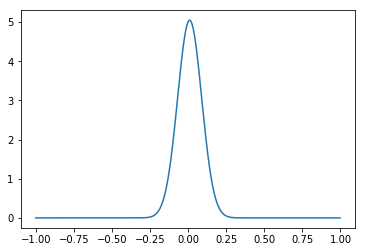

In [11]:
T = 0.1
N = 512 
a, b = char_fun.get_ab(T)
interval = (-1., 1.)

# the function get_values is imported from the density notebook 
values = get_values(a,b,char_fun.evaluate,N,interval, T)
plt.plot(*values);

## 5.3. The Heston Model

In [12]:
K = np.array([100])  # strike price
S = 100 
char_fun = HestonCharFunction()

specifications = (K,S,char_fun,'call')

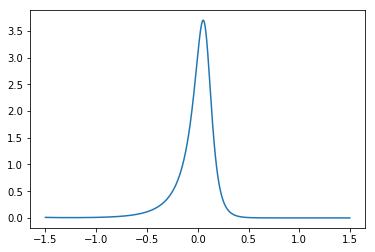

In [13]:
T = 1
N = 512 
a, b = char_fun.get_ab(T)
interval = (-1.5, 1.5)

# the function get_values is imported from the density notebook 
values = get_values(a,b,char_fun.evaluate,N,interval, T)
plt.plot(*values);

In [14]:
T = 1   # years to maturity
reference_value = np.array([5.785155450])

run_experiment(T,reference_value,specifications)

Model: 		 Heston
Strike K =	 [100]
Underlying S =	 100
T =		 1
Reference val. = [5.78515545] 

N 	 max. abs. err. 	 avg.time(msec)
64 	 4.049729370336763e-05 	 0.4373598098754883
128 	 3.637363414110695e-05 	 0.36921262741088867
256 	 3.637353514918118e-05 	 0.6095266342163086
512 	 3.637353514918118e-05 	 1.045362949371338
1024 	 3.637353514918118e-05 	 1.875007152557373





In [15]:
T = 10   # years to maturity
reference_value = [22.318945791]

run_experiment(T,reference_value,specifications)

Model: 		 Heston
Strike K =	 [100]
Underlying S =	 100
T =		 10
Reference val. = [22.318945791] 

N 	 max. abs. err. 	 avg.time(msec)
64 	 0.29567295914137404 	 0.5013346672058105
128 	 0.29567295914137404 	 0.7175302505493164
256 	 0.29567295914137404 	 0.7721757888793945
512 	 0.29567295914137404 	 1.2133383750915527
1024 	 0.29567295914137404 	 1.8938636779785156





Repeat the experiment for `T=1` but now with 21 consecutive strikes, `K = [50, 55, 60, · · · , 150]`

cpu time (msec.):  15.625 



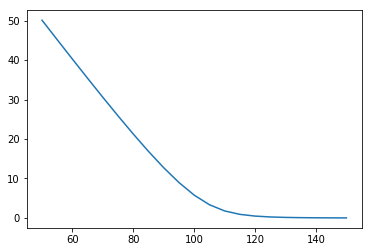

In [16]:
T=1
N=160
K = np.array([j for j in range(50,151,5)])
t = time.process_time()
prices = pricing(K, S, N, T, HestonCharFunction(), 'call')
elapsed = time.process_time()-t
print("cpu time (msec.): ", 1000*elapsed, "\n")
plt.plot(K, prices);

## 5.4. Variance Gamma, VG.

In [17]:
K = np.array([90]) # strike price, ndarray
S = 100              # initial price
specifications = (K,S,LevyCharFunction('VG'),'call')

### Table 7

In [18]:
T = .1
reference_value = [10.993703187]

run_experiment(T, reference_value, specifications)

T = 1
reference_value = [19.099354724]
run_experiment(T, reference_value, specifications)

Model: 		 VG
Strike K =	 [90]
Underlying S =	 100
T =		 0.1
Reference val. = [10.993703187] 

N 	 max. abs. err. 	 avg.time(msec)
64 	 0.025052730035806547 	 0.41112184524536133
128 	 0.02505236478312156 	 0.32612085342407227
256 	 0.02505236478312156 	 0.48126220703125
512 	 0.02505236478312156 	 0.5766153335571289
1024 	 0.02505236478312156 	 0.9792613983154297



Model: 		 VG
Strike K =	 [90]
Underlying S =	 100
T =		 1
Reference val. = [19.099354724] 

N 	 max. abs. err. 	 avg.time(msec)
64 	 0.3543466333416845 	 0.3108406066894531
128 	 0.35434663342911676 	 0.3258657455444336
256 	 0.35434663342911676 	 0.37602901458740234
512 	 0.35434663342911676 	 0.6818628311157227
1024 	 0.35434663342911676 	 0.8673429489135742





### Fig. 4. Recovered density functions for the VG model and two maturity dates

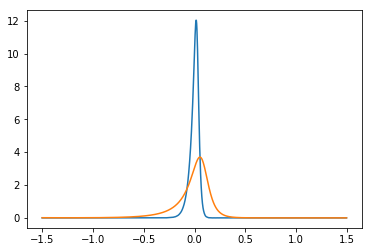

In [19]:
interval = (-1.5, 1.5)
for T in (0.1, 1.):
    values = get_values(a,b,char_fun.evaluate,N,interval, T)
    plt.plot(*values)

## 5.5. CGMY

### Table 8: Accuracy and speed for CGMY with Y=0.5

In [20]:
K = np.array([100]) # strike price, ndarray
S = 100              # initial price
T = 1.

char_fun = LevyCharFunction('CGMY')
char_fun.Y = 0.5

specifications = (K,S,char_fun,'call')

reference_value = [19.812948843]
run_experiment(T, reference_value,specifications)


Model: 		 CGMY
Strike K =	 [100]
Underlying S =	 100
T =		 1.0
Reference val. = [19.812948843] 

N 	 max. abs. err. 	 avg.time(msec)
64 	 7.199045327440523 	 0.416104793548584
128 	 7.1990456085691505 	 0.36095380783081055
256 	 7.1990456085691505 	 0.5013322830200195
512 	 7.1990456085691505 	 0.7670378684997559
1024 	 7.1990456085691505 	 1.3786649703979492





Regarding Table 8: The error rate is relatively large, which indicates that there is a mistake in the implementation of the CGMY algorithm. The mistake has yet to be found.


### Table 9: Accuracy and speed for CGMY with Y=1.5

In [21]:
K = np.array([100]) # strike price, ndarray
S = 100              # initial price

char_fun = LevyCharFunction('CGMY')

# we can easily specify a different Y value for the CGMY model by
char_fun.Y = 1.5

reference_value = [49.790905469]
T = 1.

specifications = (K,S,char_fun,'call')

run_experiment(T, reference_value,specifications)

Model: 		 CGMY
Strike K =	 [100]
Underlying S =	 100
T =		 1.0
Reference val. = [49.790905469] 

N 	 max. abs. err. 	 avg.time(msec)
64 	 105.15083453622398 	 0.42157888412475586
128 	 105.15083453622398 	 0.4916715621948242
256 	 105.15083453622398 	 0.5815744400024414
512 	 105.15083453622398 	 0.9728360176086426
1024 	 105.15083453622398 	 1.2325477600097656





Regarding Table 9: The error rate is relatively large, which indicates that there is a mistake in the implementation of the CGMY algorithm. The mistake has yet to be found.

### Fig. 6: Recovered density functions for the CGMY model with diﬀerent values of Y

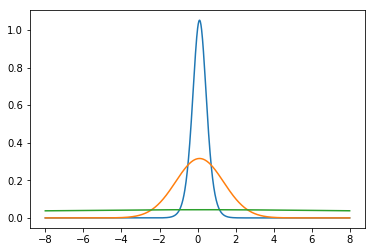

In [22]:
N = 1024 
a, b = char_fun.get_ab(T)
interval = (-8, 8)

for Y in (0.5, 1.5, 1.98):
    char_fun.Y = Y
    values = get_values(a,b,char_fun.evaluate,N,interval, T)
    plt.plot(*values)  

Regarding Figure 6: The recovered densities don’t look quite correct. This might be due to a mistake in the implementation of the CGMY algorithm. The error has yet to be found.

# Extra: Speed Test of vectorized vs. unvectorized Pricing

In [23]:
def slow_pricing(K, S, N, tau, char_fun, style):
    """
    This is similar to the pricing function above (eq 30), but does not 
    use the matrix-vector product to speed up computation but 
    a simple for loop over all k.
    """
    x = np.log(S/K)   #from page 6
    
    a, b = char_fun.get_ab(tau)
    
    r_param = char_fun.r
    q_param = char_fun.q
    
    prices = np.zeros(len(K)) 
     
    sum_over_k = 0
    
    for k in range(N):
        
        ome = k * np.pi / (b-a)  # the expression inside the characteristic fn

        phi_omega = char_fun.evaluate(ome, tau)
        
        exponential = np.exp(1j * ome * (x -a))        
        
        summand = phi_omega*UK(k,a,b,style)*exponential
        
        # first summand is only half weighted
        if k == 0:
            sum_over_k += 0.5*summand
            
        else:
            sum_over_k += summand
            
    return K*cmath.exp(-r_param*tau)*np.real(sum_over_k)

In [24]:
def speed_test(T, ref_values, specifications):
    
    K,S,char_fun,style = specifications

    print("Model: \t\t", char_fun.model)
    print("Strike K =\t", K)
    print("Underlying S =\t", S)
    print("T =\t\t", T)
    print("Reference val. =", ref_values, "\n")
        
    for pricing_fn in (pricing, slow_pricing):
        print(pricing_fn.__name__)
        print("N \t max. abs. err. \t avg.time(msec)") 
        for w in range(6,11):
            N = 2**w
            prices = pricing_fn(K, S, N, T, char_fun, style)
            errors = ref_values-prices
            max_abs_error = max(abs(errors))

            start = time.time()
            for i in range(100):
                pricing_fn(K, S, N, T, char_fun, style)
            elapsed_time = (time.time() - start)

            # average and convert to milliseconds
            elapsed_time = 1000*elapsed_time/100
            
            print("%s \t %s \t %s" % (N, max_abs_error, elapsed_time))
        print("\n")
    print("\n\n")

In [25]:
K = np.array([100])  # strike price
S = 100 
specifications = (K,S,HestonCharFunction(),'call')

T = 1   # years to maturity
reference_value = [5.785155450]

speed_test(T,reference_value,specifications)

Model: 		 Heston
Strike K =	 [100]
Underlying S =	 100
T =		 1
Reference val. = [5.78515545] 

pricing
N 	 max. abs. err. 	 avg.time(msec)
64 	 4.049729370336763e-05 	 0.38607120513916016
128 	 3.637363414110695e-05 	 0.2873539924621582
256 	 3.637353514918118e-05 	 0.6652450561523438
512 	 3.637353514918118e-05 	 0.9172725677490234
1024 	 3.637353514918118e-05 	 1.4534378051757812


slow_pricing
N 	 max. abs. err. 	 avg.time(msec)
64 	 4.0497293701591275e-05 	 4.683420658111572
128 	 3.637363413933059e-05 	 8.853795528411865
256 	 3.6373535148293e-05 	 17.60035276412964
512 	 3.6373535148293e-05 	 36.08314037322998
1024 	 3.6373535148293e-05 	 74.6331524848938





